In [33]:
import pandas as pd
import yfinance as yf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'ADBE', 'INTC']

start_date = '2015-01-01'
end_date = '2021-01-01'

df = pd.DataFrame()

# Get data from Yahoo Finance. Loop through tickers and append to df
for ticker in tickers:
    tmp_df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    tmp_df['ticker'] = ticker
    # Keep index, Adj Close, Volume and ticker
    tmp_df = tmp_df[['Adj Close', 'Volume', 'ticker']]
    df = pd.concat([df, tmp_df], ignore_index=False)

# Apply log to Adj Close and Volume
df['Adj Close'] = df['Adj Close'].apply(lambda x: np.log(x))
df['Volume'] = df['Volume'].apply(lambda x: np.log(x))

# Reframe to have tickers as columns
df = df.pivot(columns='ticker')
df.columns = ['_'.join(col).strip() for col in df.columns.values]

# Calculate returns
for ticker in tickers:
    df[ticker + '_return'] = df['Adj Close_' + ticker].diff()

df = df.fillna(0)

# Run PCA to get factor loadings
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[[ticker + '_return' for ticker in tickers]])

# Run PCA
pca = PCA(n_components=5)

pca.fit(scaled_data)

# Get factor loadings
factor_loadings = pd.DataFrame(pca.components_.T, index=df[[ticker + '_return' for ticker in tickers]].columns, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

factor_series = pd.DataFrame(pca.transform(scaled_data), index=df.index, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

# Calculate the residuals from the PCA
residuals = df[[ticker + '_return' for ticker in tickers]] - np.dot(factor_series, factor_loadings.T)
# Rename residuals
residuals.columns = [ticker for ticker in tickers]

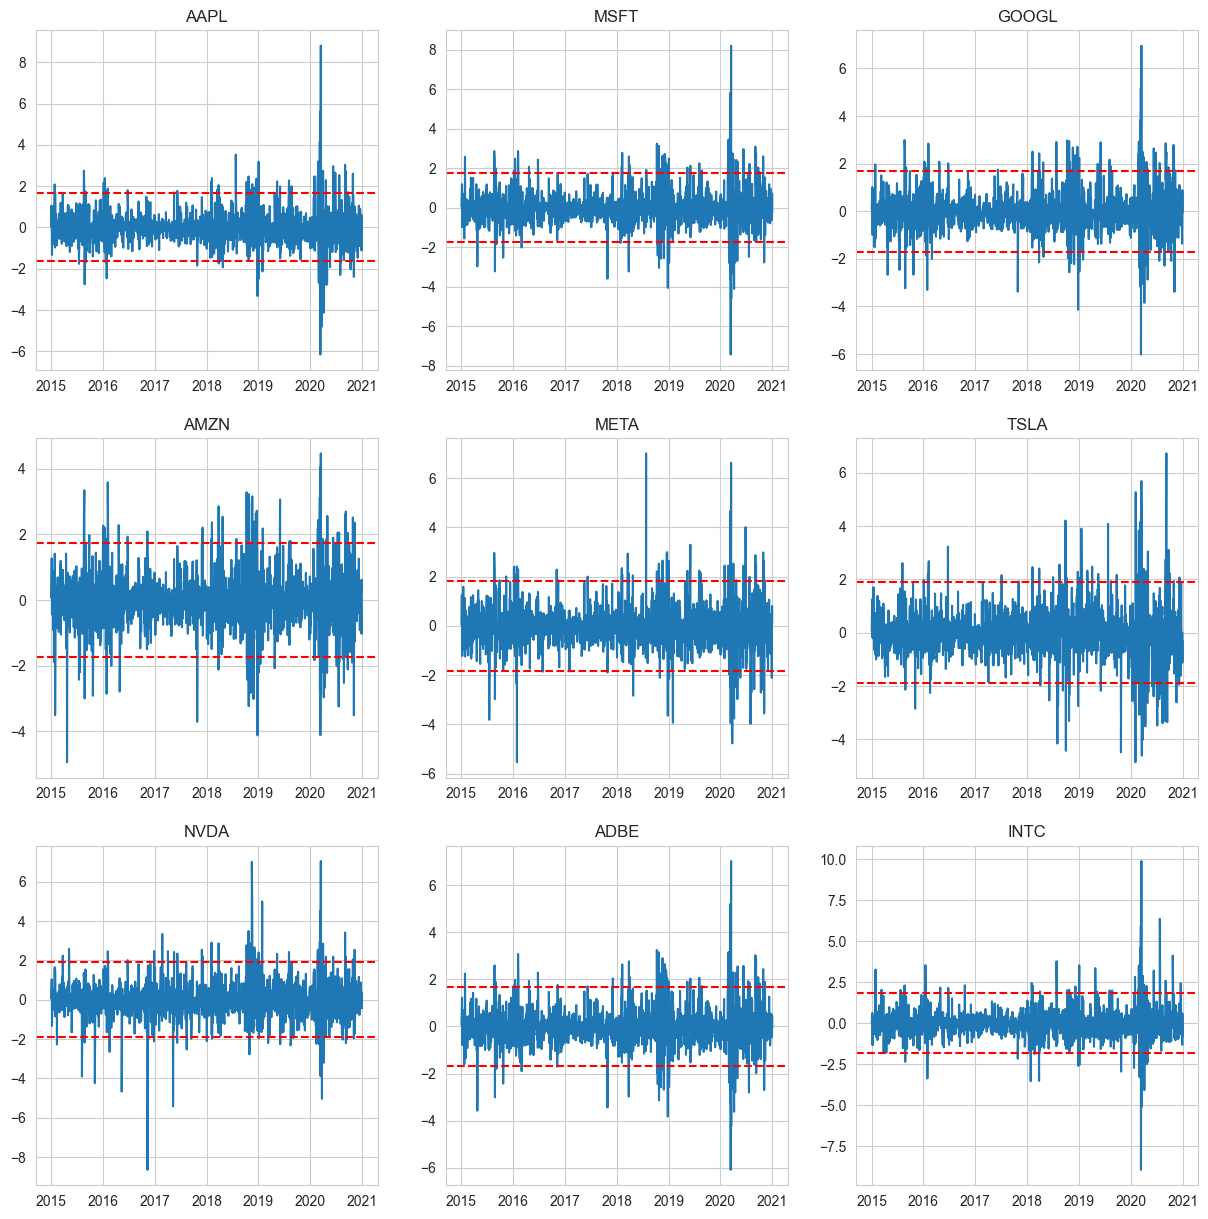

In [62]:
# Plot residuals
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, ticker in enumerate(tickers):
    ax[i//3, i%3].plot(residuals[ticker])
    ax[i//3, i%3].set_title(ticker)
    # Add 95% confidence interval
    ax[i//3, i%3].axhline(y=1.96*residuals[ticker].std(), color='r', linestyle='--')
    ax[i//3, i%3].axhline(y=-1.96*residuals[ticker].std(), color='r', linestyle='--')

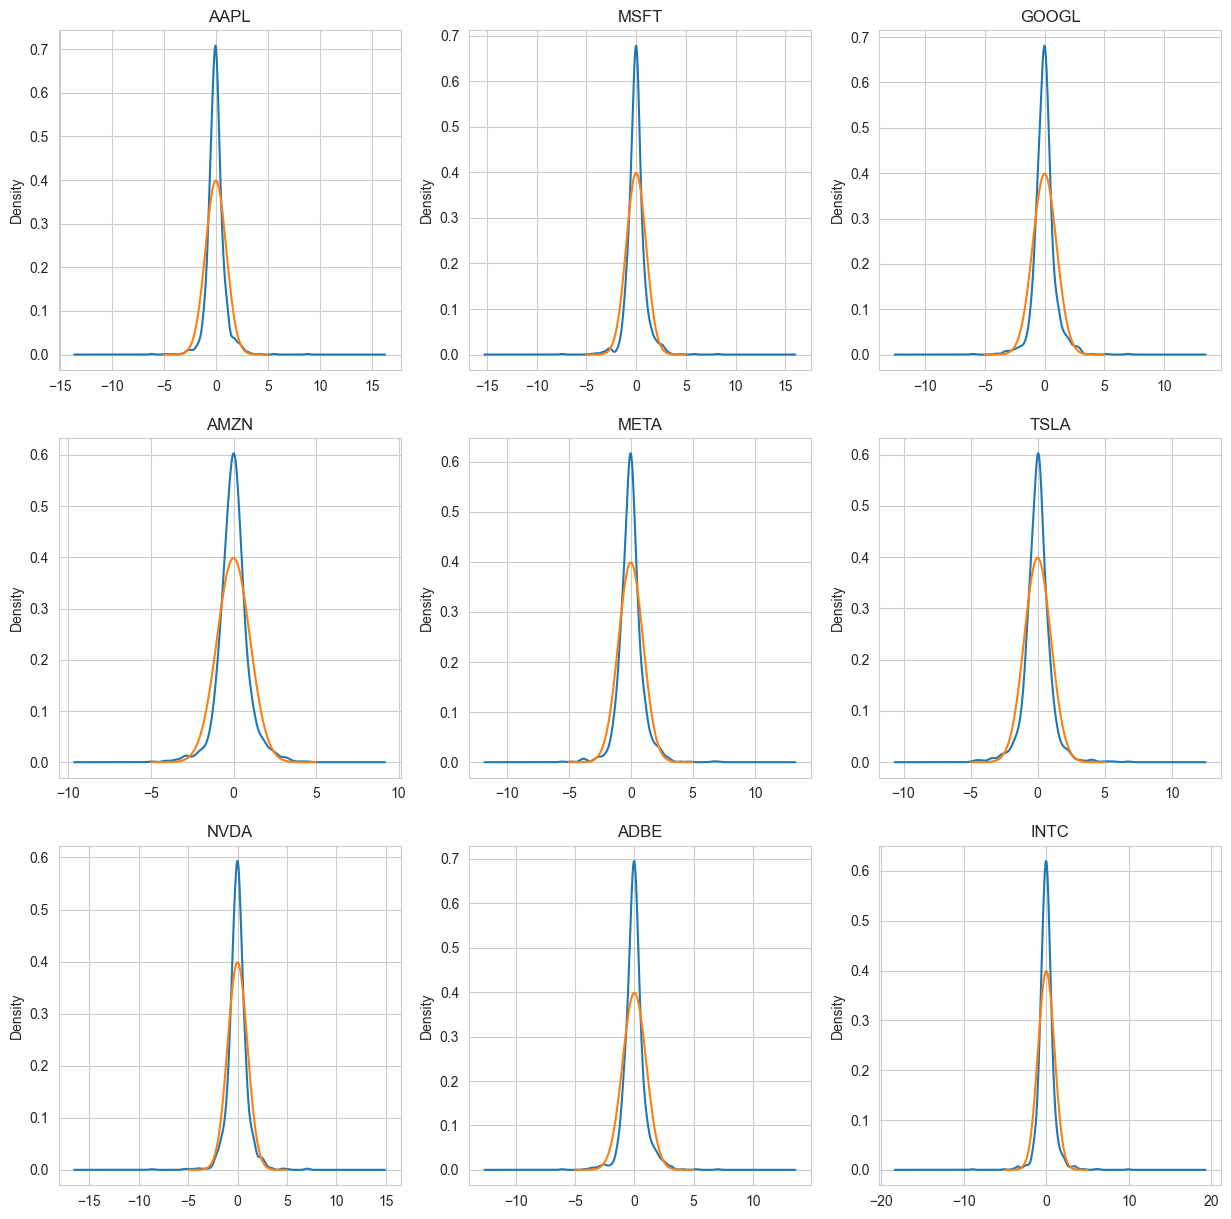

In [65]:
# Plot kde of residuals
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, ticker in enumerate(tickers):
    residuals[ticker].plot.kde(ax=ax[i//3, i%3])
    # Compare to normal distribution(0,1)
    ax[i//3, i%3].set_title(ticker)
    

In [57]:
import numpy as np
import pandas as pd
from scipy.fftpack import fft, ifft
from sklearn.linear_model import LinearRegression

def calc_fft(series):
    N = len(series)
    fft_vals = np.abs(fft(series.to_numpy()))
    freqs = np.fft.fftfreq(N)
    return pd.Series(fft_vals[:N//2], index=freqs[:N//2])

def fft_filter(series, cutoff_freq):
    N = len(series)
    fft_vals = fft(series.to_numpy())
    freqs = np.fft.fftfreq(N)
    fft_vals[freqs > cutoff_freq] = 0
    return ifft(fft_vals).real

def train_model(data, start, end):
    # Prepare data for linear regression model
    X = np.arange(start, end).reshape(-1, 1)
    y = data[start:end]

    # Fit the model
    model = LinearRegression()
    model.fit(X, y)
    return model

def trade(data, model):
    residuals = data - model.predict(np.arange(len(data)).reshape(-1, 1))
    residuals_fft = pd.Series(fft_filter(residuals, cutoff_freq=0.05))

    # Define trading rules
    long_positions = np.where(residuals_fft.shift() < 0, 1, 0)
    short_positions = np.where(residuals_fft.shift() > 0, -1, 0)
    positions = long_positions + short_positions

    # Calculate profits. Assume we can trade at close price
    profits = positions * data
    return profits.cumsum()

In [58]:
# Train model and trade
profits = pd.DataFrame()
for ticker in tickers:
    model = train_model(residuals[ticker], start=0, end=1000)
    profits[ticker] = trade(residuals[ticker], model)

In [59]:
test = train_model(residuals['AAPL'], start=0, end=1000)

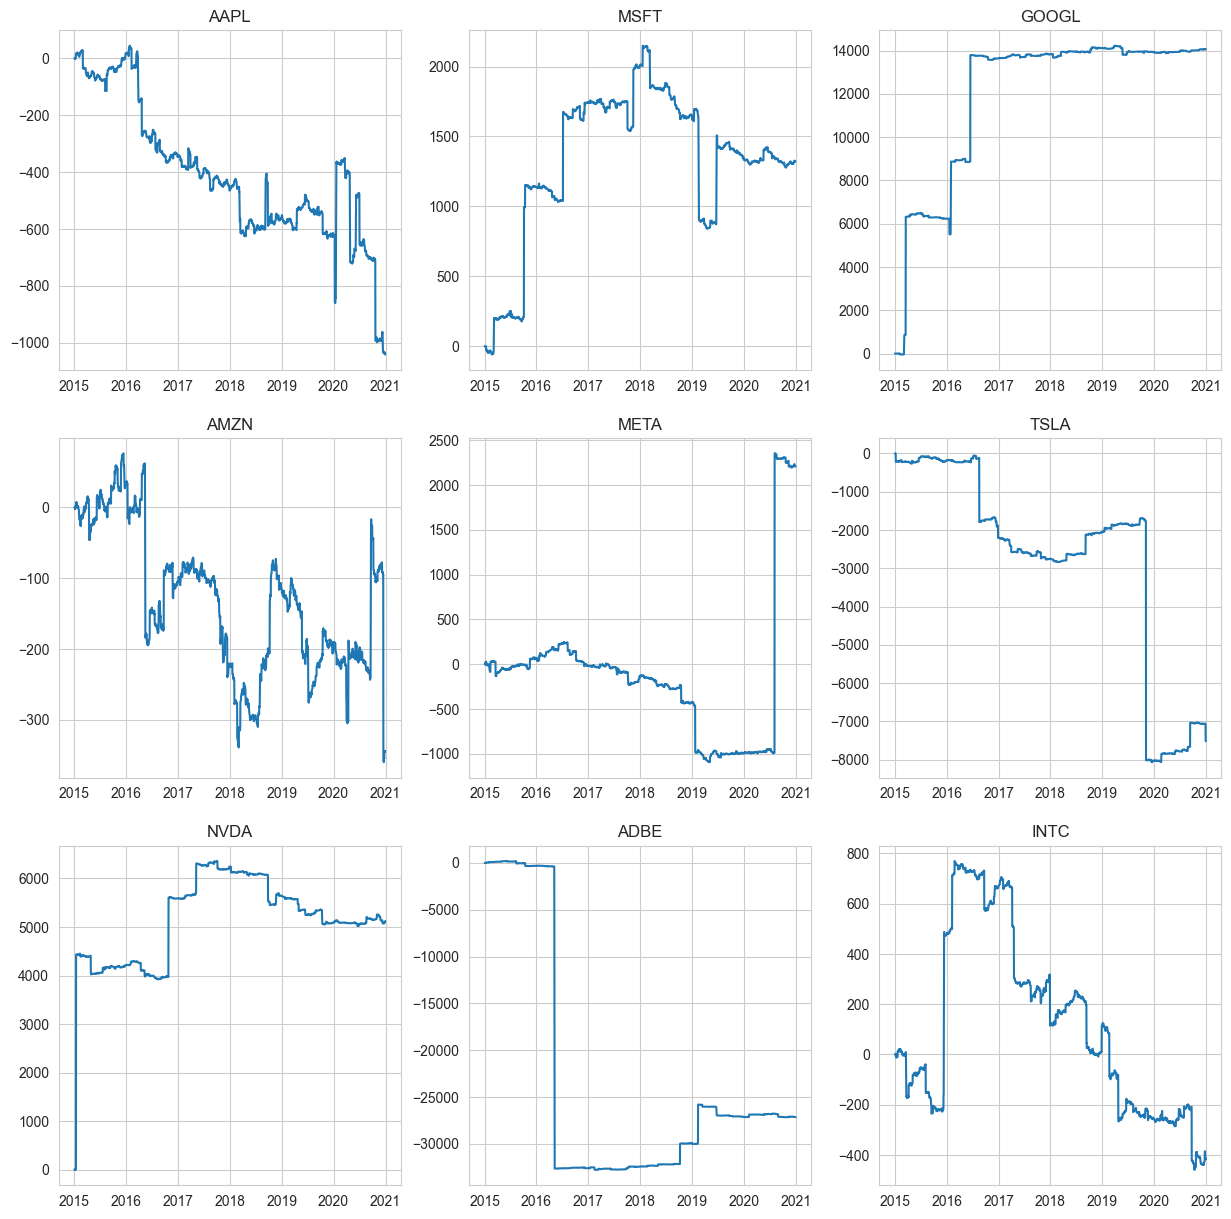

In [60]:
# Plot profits
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, ticker in enumerate(tickers):
    ax[i//3, i%3].plot(profits[ticker])
    ax[i//3, i%3].set_title(ticker)